<h2>1. Visualise the Original Data</h2>

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and parse date
df=pd.read_csv(r"C:\Users\HP\OneDrive\Desktop\Project3\Power-Supply\PJMW_hourly.csv")  # Replace with your actual file
df['Datetime'] = pd.to_datetime(df['Datetime'], dayfirst=True)
df.set_index('Datetime', inplace=True)
df = df.sort_index()


In [115]:
df

,Unnamed: 0,PJMW
Datetime,,
2002-04-01 01:00:00,0,4374.0
2002-04-01 02:00:00,1,4306.0
2002-04-01 03:00:00,2,4322.0
2002-04-01 04:00:00,3,4359.0
2002-04-01 05:00:00,4,4436.0
...,...,...
2018-08-02 20:00:00,143227,6545.0
2018-08-02 21:00:00,143228,6496.0
2018-08-02 22:00:00,143229,6325.0


In [87]:
df.head()

,Unnamed: 0,PJMW
Datetime,,
2002-04-01 01:00:00,0,4374.0
2002-04-01 02:00:00,1,4306.0
2002-04-01 03:00:00,2,4322.0
2002-04-01 04:00:00,3,4359.0
2002-04-01 05:00:00,4,4436.0


In [91]:
df.columns

Index(['Unnamed: 0', 'PJMW'], dtype='object')

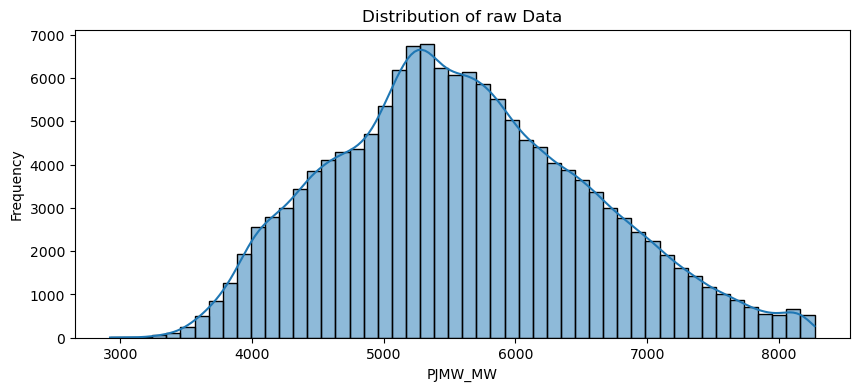

In [131]:
#Histogram showing distribution of data
import seaborn as sns
plt.figure(figsize=(10, 4))
sns.histplot(df['PJMW'].dropna(),bins=50, kde=True)
plt.title('Distribution of raw Data')
plt.xlabel('PJMW_MW')
plt.ylabel('Frequency')
plt.show()

<h3>Detect and treat outliers</h3>


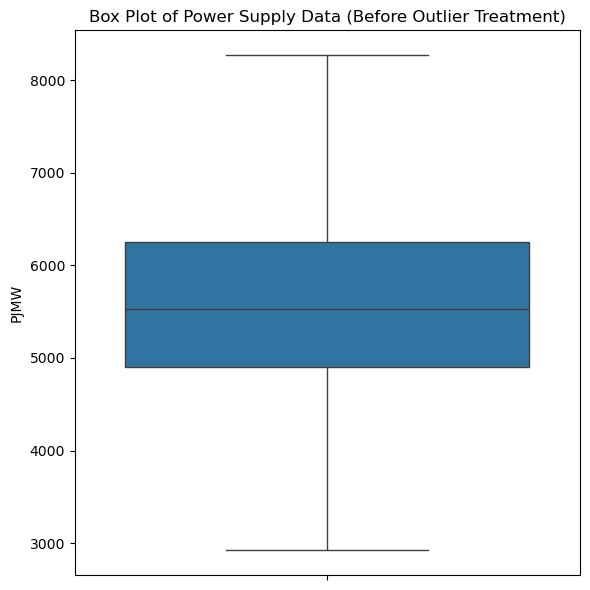

In [136]:
plt.figure(figsize=(6, 6))
sns.boxplot(y=df['PJMW'])
plt.title('Box Plot of Power Supply Data (Before Outlier Treatment)')
plt.tight_layout()
plt.show()

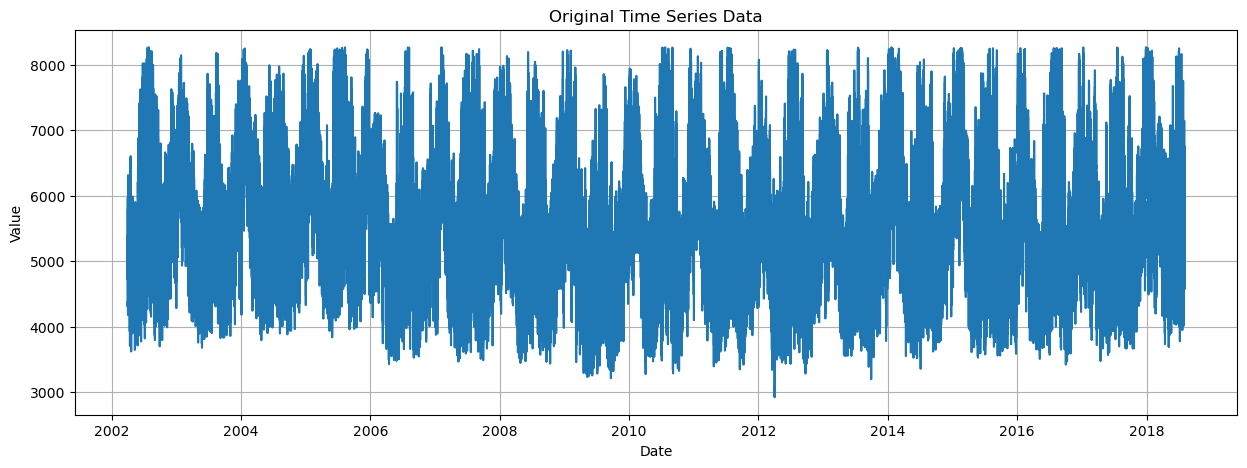

In [93]:
# Plot
plt.figure(figsize=(15, 5))
plt.plot(df[ 'PJMW'])  # Replace with actual value column
plt.title("Original Time Series Data")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.show()

<h2>2. ETS Decomposition using STL</h2>

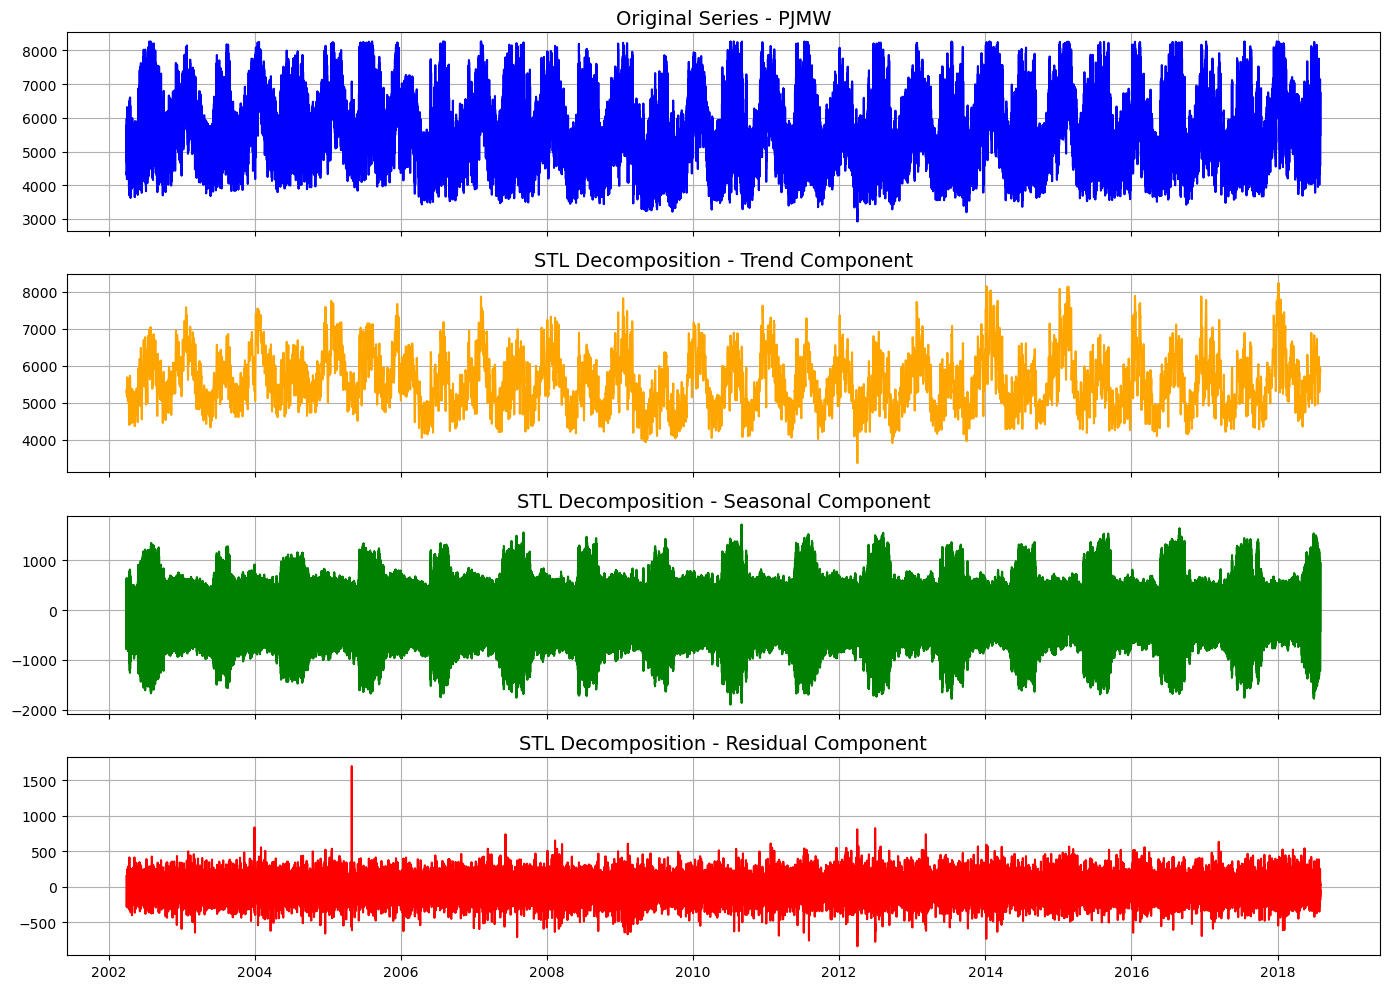

In [123]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Apply STL decomposition
stl = STL(df['PJMW'], period=24)  # adjust 'period' as needed (e.g., 24 for hourly daily seasonality)
res = stl.fit()

# Create figure with 4 subplots (including original PJMW)
fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Original Series (PJMW)
axs[0].plot(df.index, df['PJMW'], color='blue')
axs[0].set_title("Original Series - PJMW", fontsize=14)
axs[0].grid(True)

# Trend Component
axs[1].plot(df.index, res.trend, color='orange')
axs[1].set_title("STL Decomposition - Trend Component", fontsize=14)
axs[1].grid(True)

# Seasonal Component
axs[2].plot(df.index, res.seasonal, color='green')
axs[2].set_title("STL Decomposition - Seasonal Component", fontsize=14)
axs[2].grid(True)

# Residual Component
axs[3].plot(df.index, res.resid, color='red')
axs[3].set_title("STL Decomposition - Residual Component", fontsize=14)
axs[3].grid(True)

plt.tight_layout()
plt.show()


<H3>3. Test for Stationarity (ADF Test)</H3>

In [144]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['PJMW'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -19.956464490330823
p-value: 0.0


<h3>4. Downsample to Daily & Plot ACF/PACF for First 100 Days</h3>

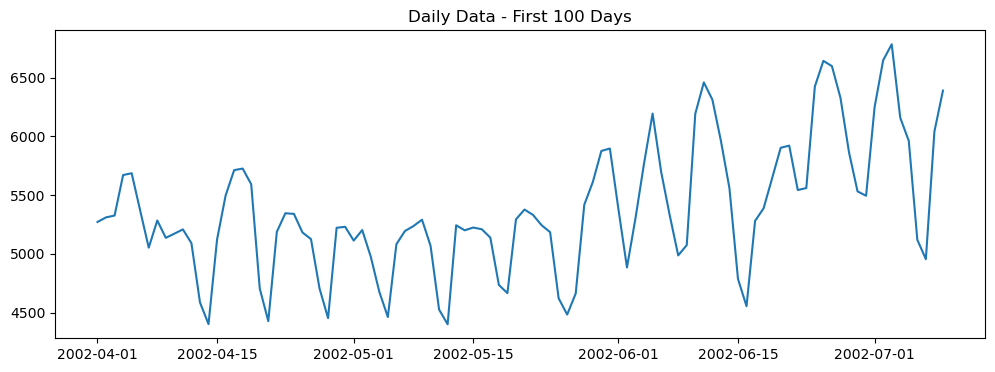

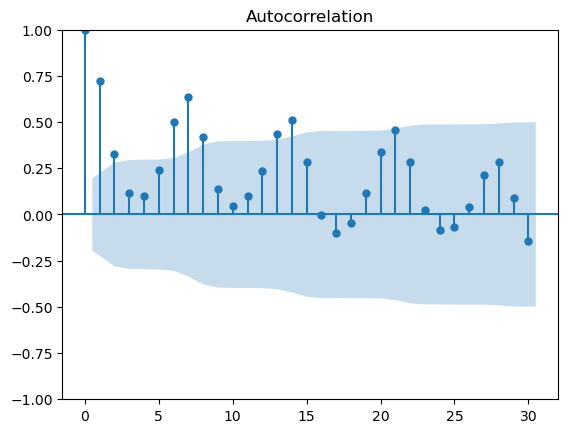

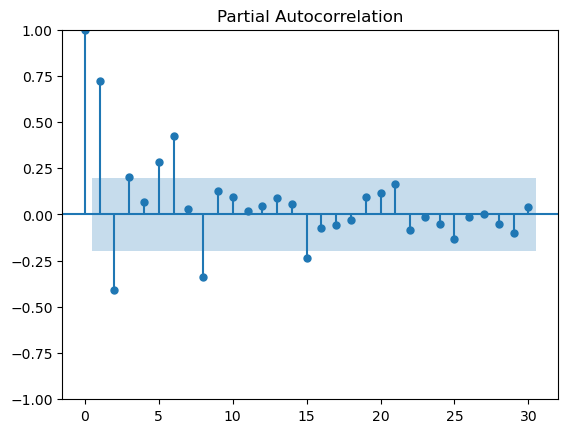

In [147]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

daily_df = df['PJMW'].resample('D').mean()
first_100_days = daily_df.iloc[:100]

plt.figure(figsize=(12, 4))
plt.plot(first_100_days)
plt.title("Daily Data - First 100 Days")
plt.show()

plot_acf(first_100_days.dropna(), lags=30)
plot_pacf(first_100_days.dropna(), lags=30)
plt.show()


<h3>5. Lag Feature Engineering</h3>

In [154]:
def create_lags(series, lags=[1, 2, 3, 7]):
    df_lagged = pd.DataFrame({'t': series})
    for lag in lags:
        df_lagged[f'lag_{lag}'] = series.shift(lag)
    df_lagged.dropna(inplace=True)
    return df_lagged

daily_df = df['PJMW'].resample('D').mean()
lagged_df = create_lags(daily_df, lags=[1, 2, 3, 7])  # Example lags


In [158]:
print(daily_df)
print(lagged_df)

Datetime
2002-04-01    5271.173913
2002-04-02    5310.416667
2002-04-03    5325.916667
2002-04-04    5670.791667
2002-04-05    5686.125000
                 ...     
2018-07-30    5492.708333
2018-07-31    5660.750000
2018-08-01    5959.708333
2018-08-02    5805.041667
2018-08-03    5489.000000
Freq: D, Name: PJMW, Length: 5969, dtype: float64
                      t        lag_1        lag_2        lag_3        lag_7
Datetime                                                                   
2002-04-08  5283.875000  5052.479167  5367.791667  5686.125000  5271.173913
2002-04-09  5136.083333  5283.875000  5052.479167  5367.791667  5310.416667
2002-04-10  5171.666667  5136.083333  5283.875000  5052.479167  5325.916667
2002-04-11  5207.875000  5171.666667  5136.083333  5283.875000  5670.791667
2002-04-12  5090.416667  5207.875000  5171.666667  5136.083333  5686.125000
...                 ...          ...          ...          ...          ...
2018-07-30  5492.708333  5293.833333  5485.7916

<h3>6(a). Exponential Smoothing (ETS)</h3>

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


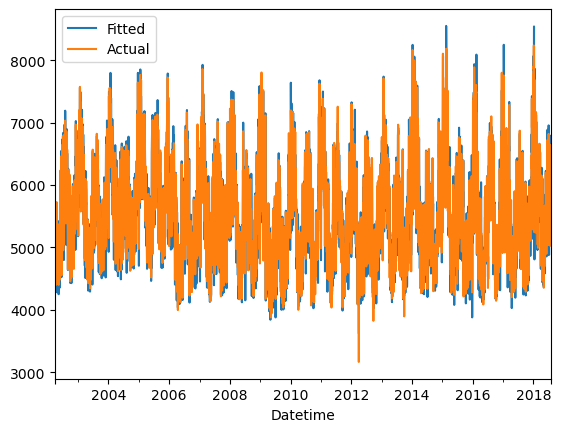

In [161]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

ets_model = ExponentialSmoothing(daily_df, trend='add', seasonal='add', seasonal_periods=7)
ets_fitted = ets_model.fit()
ets_fitted.fittedvalues.plot(label='Fitted')
daily_df.plot(label='Actual')
plt.legend()
plt.show()


<h3>6(b). ARIMA Model</h3>

                               SARIMAX Results                                
Dep. Variable:                   PJMW   No. Observations:                 5969
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -43906.772
Date:                Fri, 13 Jun 2025   AIC                          87819.543
Time:                        10:20:41   BIC                          87839.626
Sample:                    04-01-2002   HQIC                         87826.519
                         - 08-03-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4491      0.029    -15.276      0.000      -0.507      -0.392
ma.L1          0.7147      0.022     32.441      0.000       0.671       0.758
sigma2      1.438e+05   2242.938     64.111      0.0

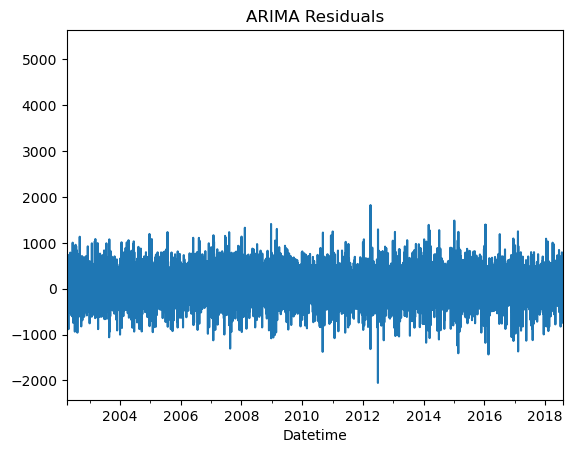

In [166]:
from statsmodels.tsa.arima.model import ARIMA

# You can determine (p,d,q) from ACF/PACF
model = ARIMA(daily_df, order=(1, 1, 1))
arima_res = model.fit()
print(arima_res.summary())

# Plot residuals
arima_res.resid.plot(title='ARIMA Residuals')
plt.show()


<h3>7. Residual Analysis</h3>

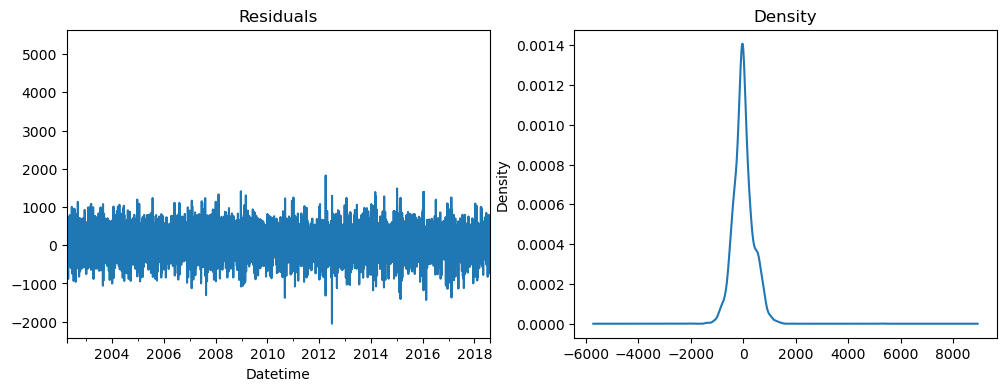

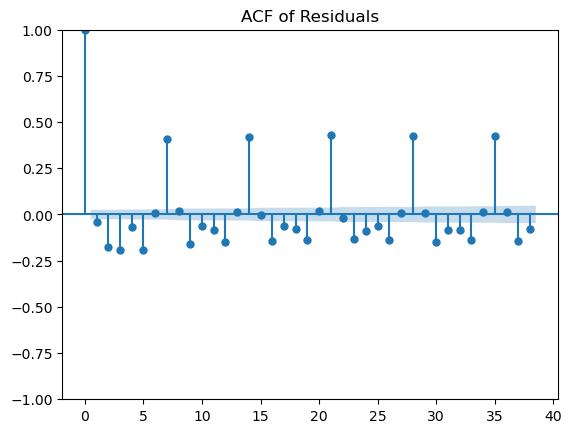

In [169]:
residuals = arima_res.resid

plt.figure(figsize=(12, 4))
plt.subplot(121)
residuals.plot(title="Residuals")
plt.subplot(122)
residuals.plot(kind='kde', title='Density')
plt.show()

# ACF of residuals
plot_acf(residuals.dropna())
plt.title("ACF of Residuals")
plt.show()
